# Weight Initialization

Looking at diferent weight initializations and why they work/ the intuition behind them.

Covering most common init techniques
- Xavier (bw/forward)
- Kaiming/He (for resid.)


### Basic Idea:
Neural networks are finicky, and not always stable in training; and the weight-intitialization is a fundamental issue to allow the network to train and converge.

We need to think about these basic factors during our intialization:
1. Number of inputs (forward pass)
2. Number of outputs (gradient)
3. Type of non-linearity

#### Questions I have:
- Why do we need to intiialize weights when we can just do layernorm after each layer (or why don't we just pick one?)

In [124]:
# testing out intialization
import torch
import torch.nn as nn

batch_size = 32
in_dim = 200
h_dim = 400

# nin,nout
input = torch.randn([32,200])
lin_1 = torch.randn([200,400])
lin_2 = torch.randn([400,800]) 

out1 = input @ lin_1
out2 = out1 @ lin_2

out2.shape


# backward pass
lin_2_grad = out1.T @ out2 * 1
out_1_grad = out2 @ lin_2.T * 1
lin_1_grad = input.T @ out_1_grad


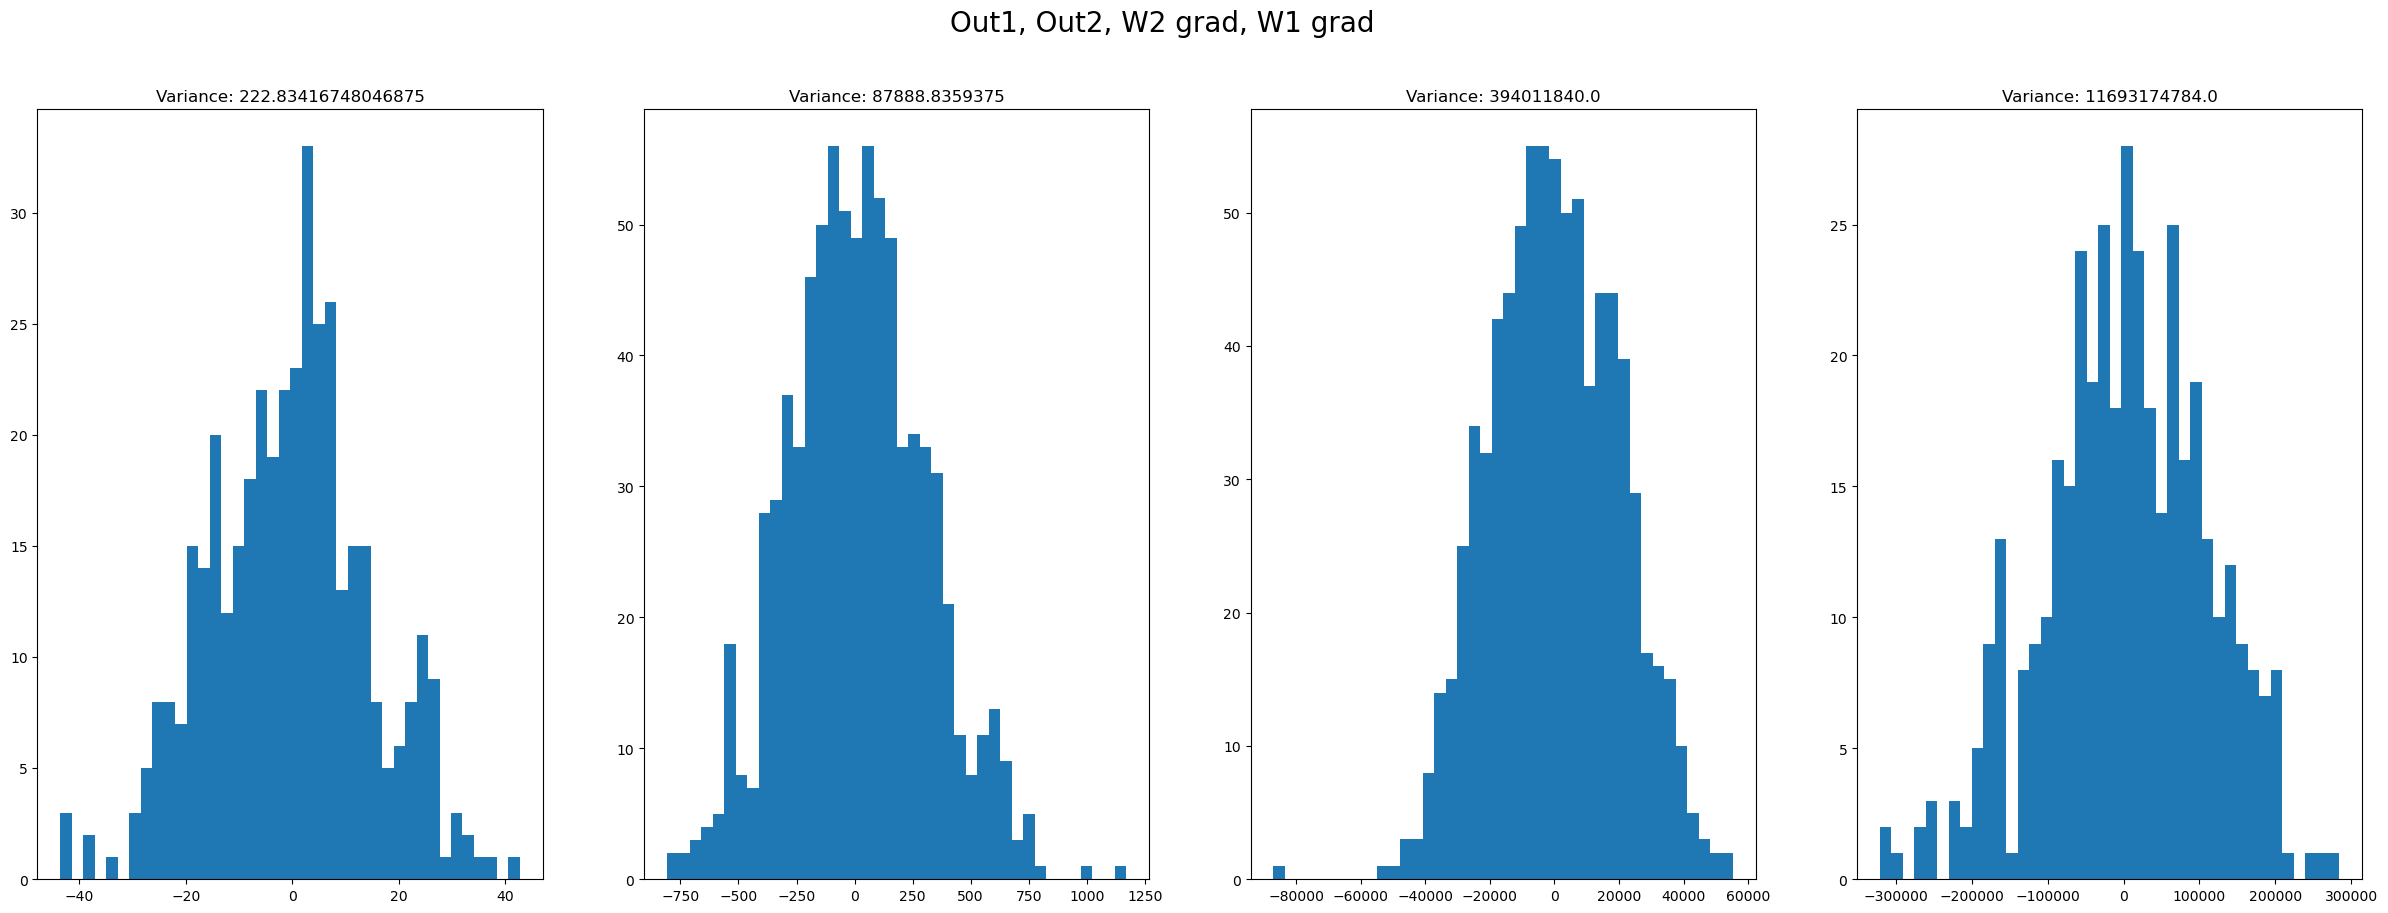

In [125]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(1,4)

variance = torch.var(out1[0],dim=-1).item()
variance2 = torch.var(out2[0],dim=-1).item()


variance_grad2 = torch.var(lin_2_grad[0],dim=-1).item()
variance_grad1 = torch.var(lin_1_grad[0],dim=-1).item()

fig.set_size_inches(30,10)

axes[0].hist(out1[0],bins=40)
axes[0].set_title(f"Variance: {variance}")
axes[1].hist(out2[0],bins=40)
axes[1].set_title(f"Variance: {variance2}")

axes[2].hist(lin_2_grad[0],bins=40)
axes[2].set_title(f"Variance: {variance_grad2}")


axes[3].hist(lin_1_grad[0],bins=40)
axes[3].set_title(f"Variance: {variance_grad1}")

fig.suptitle("Out1, Out2, W2 grad, W1 grad",fontsize=20)
plt.show()


### Problem: Variance Scales!

As we can see, our variance increases additively with the number of elements that we add! We have normally distributed weights on each tensor, and therefore two things happen:
1. We multiply each neuron by eachother (for each output)
2. We add these together

Multiplying two normal distributions (mean 0 and variance 1) results in another with the same mean and zero variance. This can be thought of as just multiplying two things that are one on average, also being equal to one. But when we add the distributions, the variance also adds!

This results in instability in the forward pass, as succesive layers grow, and in the backward pass as the same thing happens (although in a different way). Therefore, we need to mitigate this.

> We care about the scale of variance in our neural networks, because we want to have a consistent 'scale' of information. This is because, if we want each layer to learn at a similar rate, they need to have similar gradients. We can clearly see that one layer would learn faster than another if we ignored intiailizations!

So, our fundamental problem is: ***How do we preserve fundamental learning (backprop) and information representation without having different scales?***
Well, we can just do weight-intitialization!

> Note that we also need to consider non-linearities that can 'squish' our outputs. We will also need to account for these when intializing our weights.

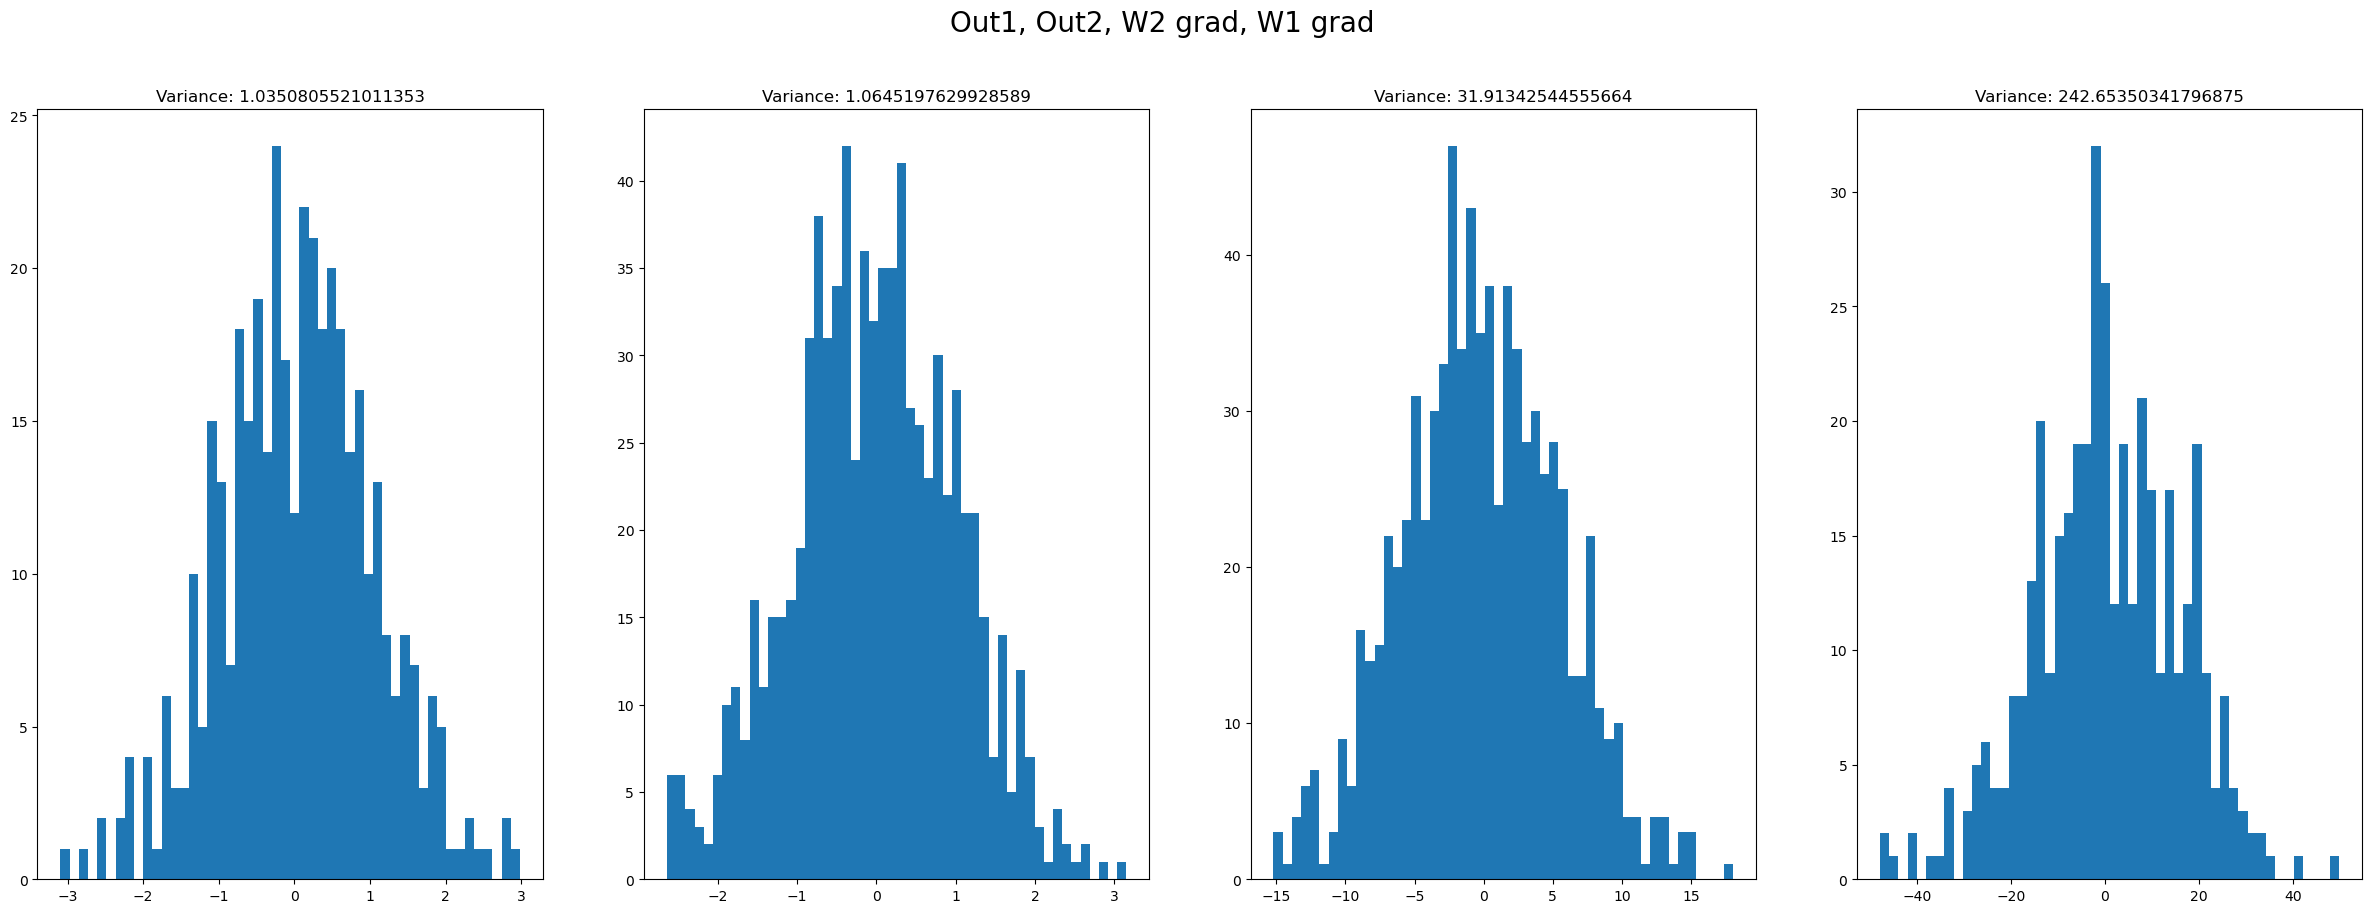

In [126]:
# solution: weight-initialization
from plot_acts import plot_layers

'''Now, we import the same linear network, and 
divide by the variance we create (number of inputs).'''

# dividing by the 'nin' amount, so that 
# we can control our variance of output neurons
var_controls = [200**0.5, 400**0.5]
plot_layers(div_amounts=var_controls,act = False)
# no activation for now

### Problem: backward gradients are scaling!

Ok, so we've solved the problem of our layers behaving in the forward pass, but now what's up with the gradients? Well, intuitively: even if the forward pass is all stable, each neuron is affecting the n_out amount of the next layer, and the next. Therefore, our gradients will scale up continoually.

So, we need to account for nin *and* nout during our weight-intialization. However, won't this create a learning bias towards neurons that affect less (nout)?

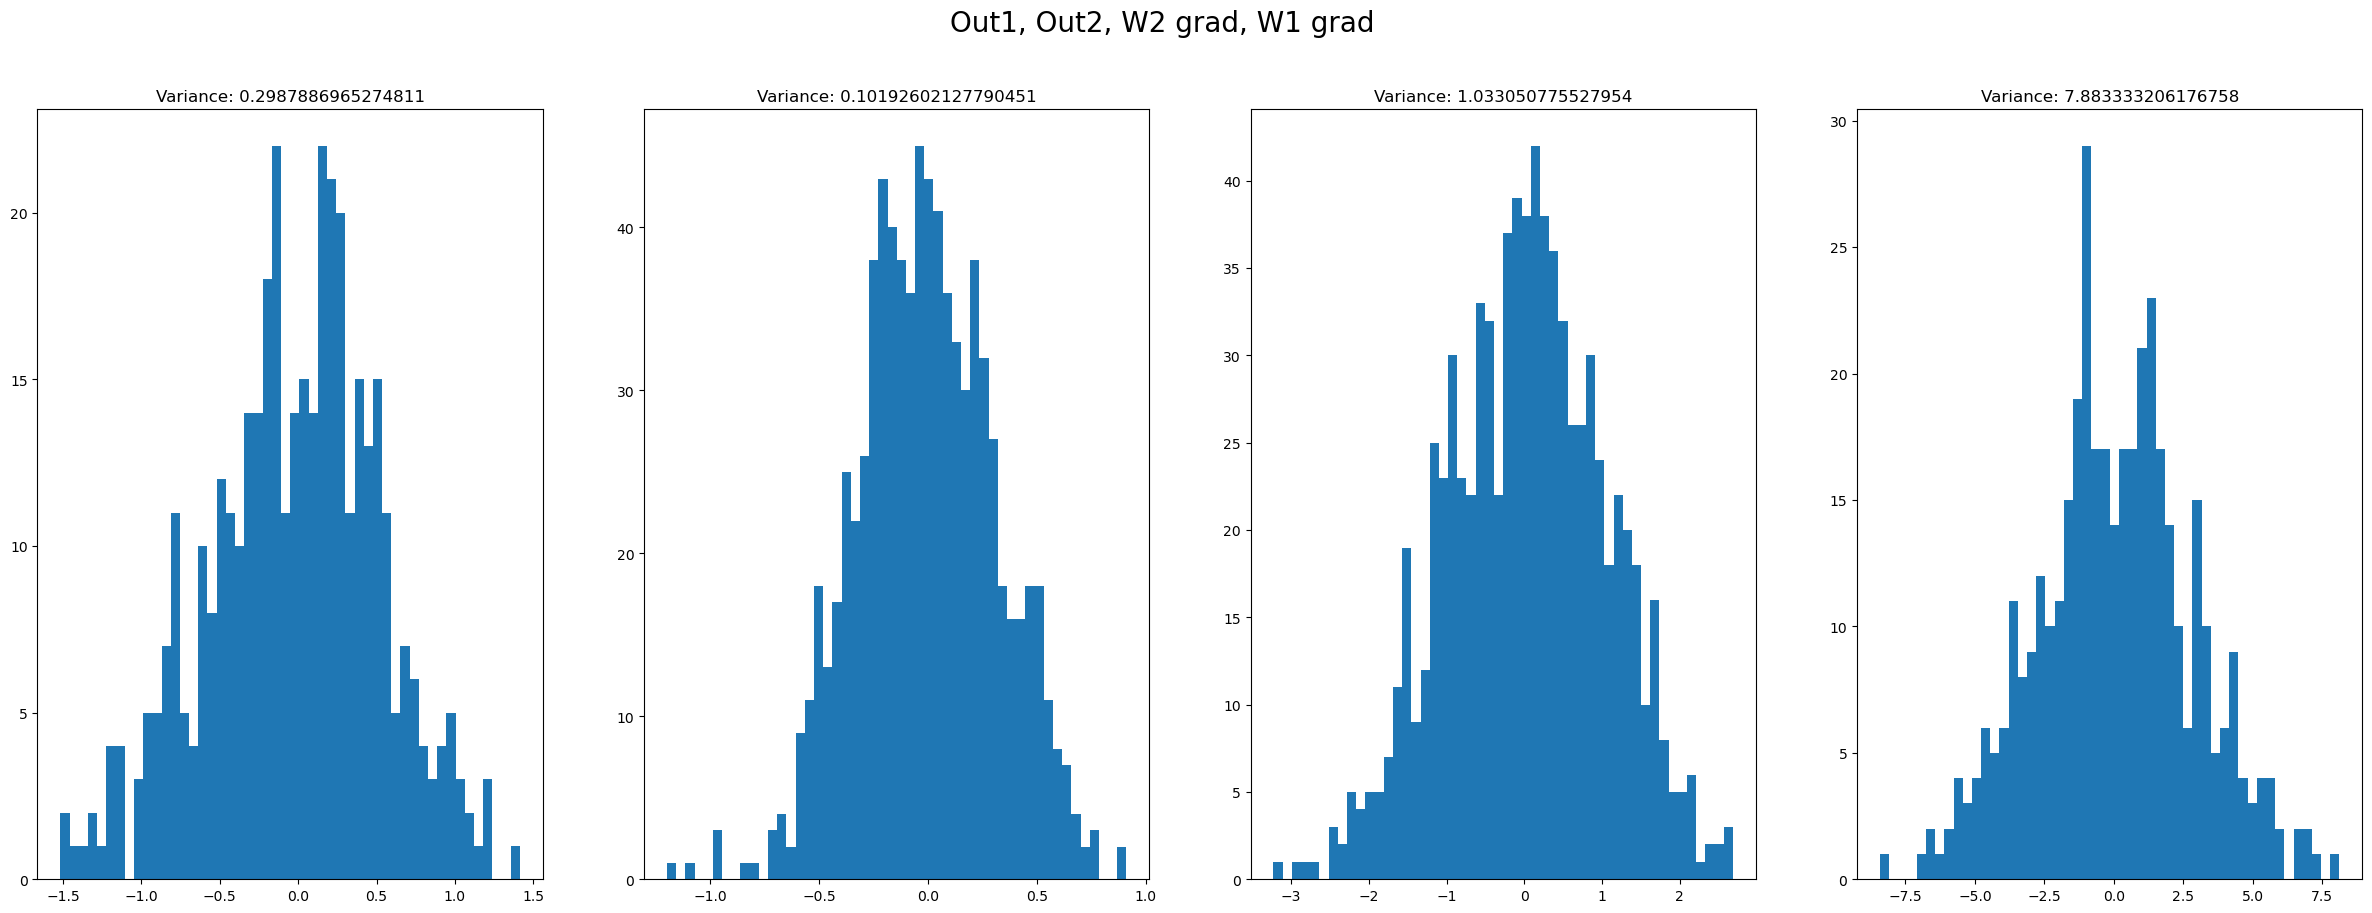

In [127]:
# let's test this:
# accounting for nin *and* nout!
var_controls = [(200+400)**0.5, (400+800)**0.5]
plot_layers(div_amounts=var_controls,act = False)

hmm...
### Testing with ReLu activation.


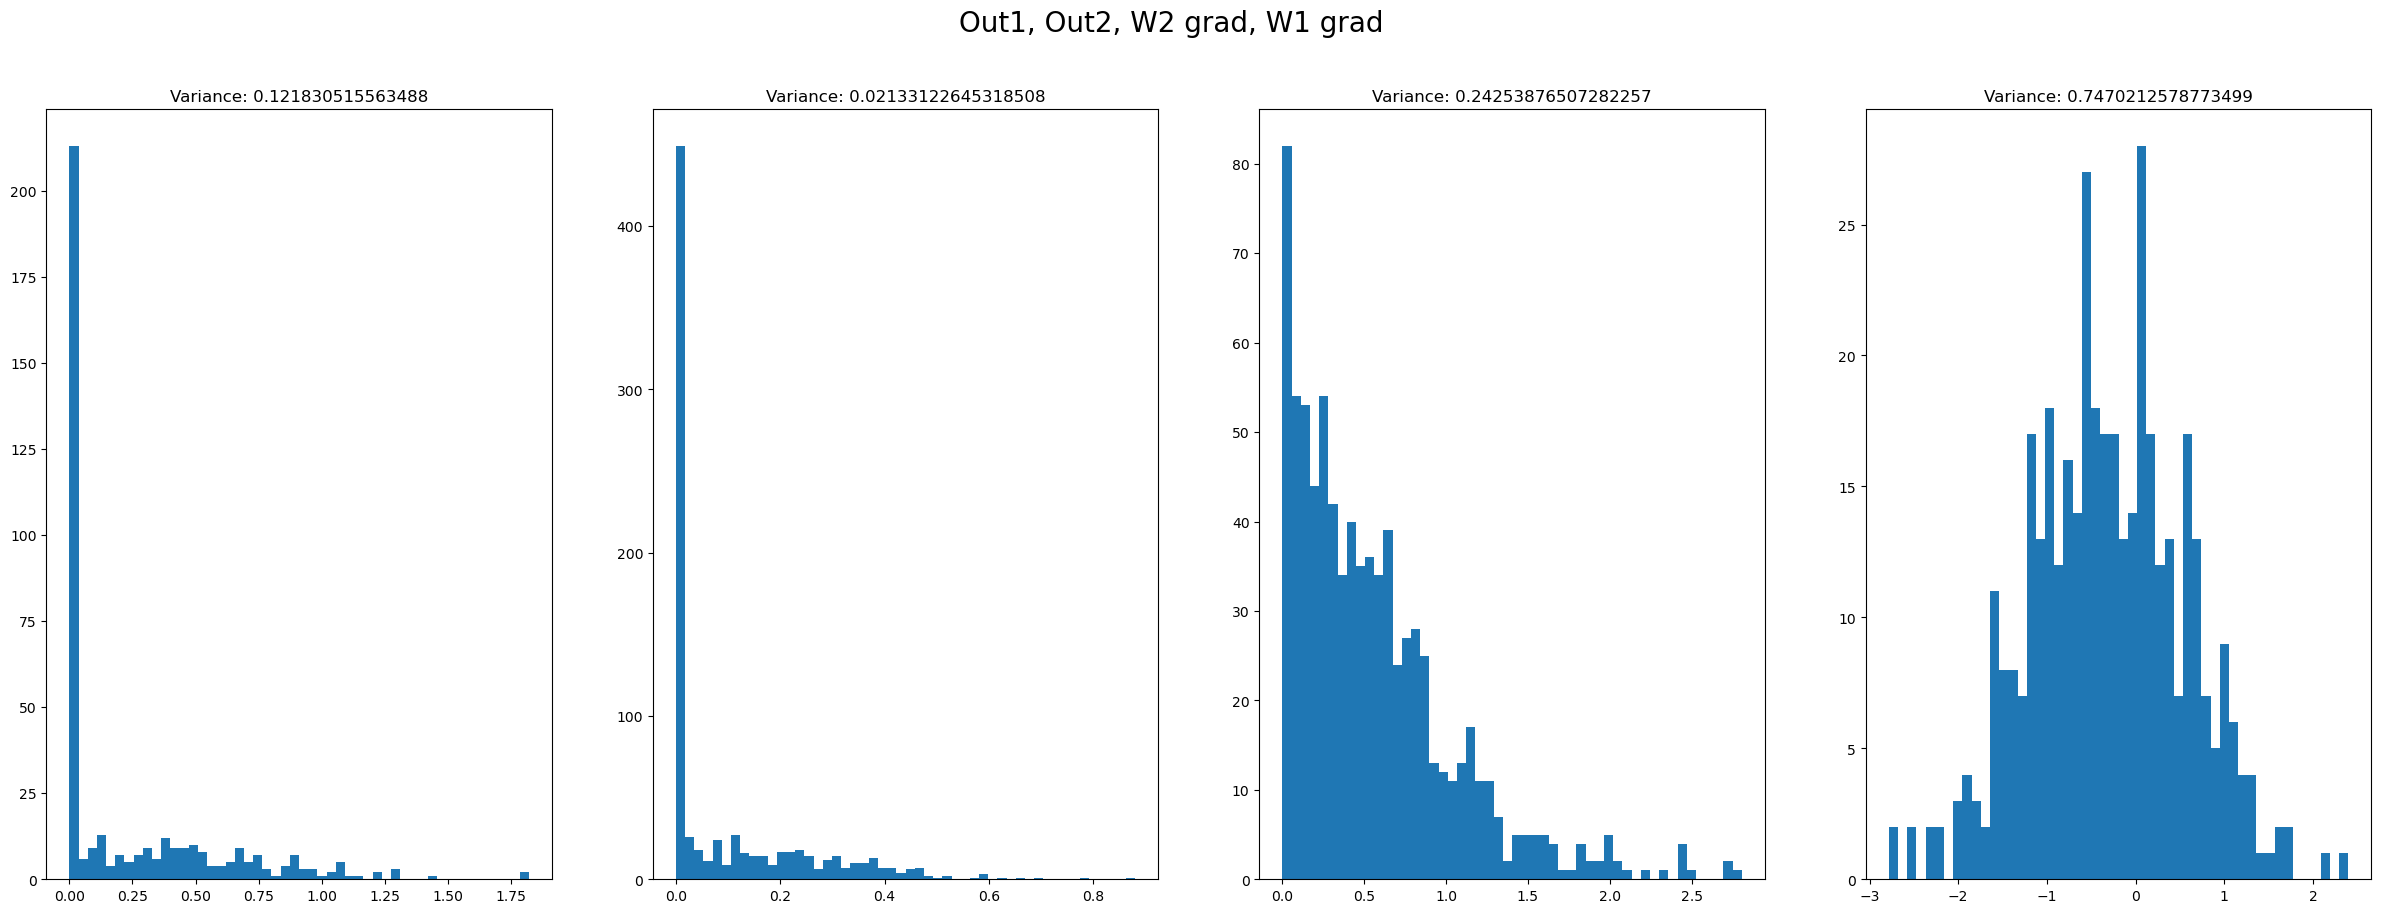

In [128]:
# let's test this:
# accounting for nin *and* nout!
var_controls = [(200+400)**0.5, (400+800)**0.5]
plot_layers(div_amounts=var_controls,act = True)

# More in-depth Expiriments

Now we have explored some of the problems of neural networks, and defined our goal, which is to have stable variance/statistics over all of our layers, let's look at more deep neural networks and analyze the following:
- Variance across multiply layers in forward and backward pass
- Introducing non-linearities and analyzing their properties (what initiliaztion for which non-linearity, and why)
- ***Introducing normalization***, and seeing why/when layer/batch/group norm and initialization is used in practice.

? ***Do different neurons with diff. outputs require higher-gradients to train?? To what extent??***

ModuleList(
  (0): Linear(in_features=128, out_features=256, bias=True)
  (1): Identity()
  (2): Linear(in_features=256, out_features=400, bias=True)
  (3): Identity()
  (4): Linear(in_features=400, out_features=256, bias=True)
  (5): Identity()
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): Identity()
)
Identity()
torch.Size([256, 128])
[ModuleList(
  (0): Linear(in_features=128, out_features=256, bias=True)
  (1): Identity()
  (2): Linear(in_features=256, out_features=400, bias=True)
  (3): Identity()
  (4): Linear(in_features=400, out_features=256, bias=True)
  (5): Identity()
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): Identity()
), Identity()]
[ModuleList(
  (0): Linear(in_features=128, out_features=256, bias=True)
  (1): Identity()
  (2): Linear(in_features=256, out_features=400, bias=True)
  (3): Identity()
  (4): Linear(in_features=400, out_features=256, bias=True)
  (5): Identity()
  (6): Linear(in_features=256, out_features=256, bias

IndexError: list index out of range

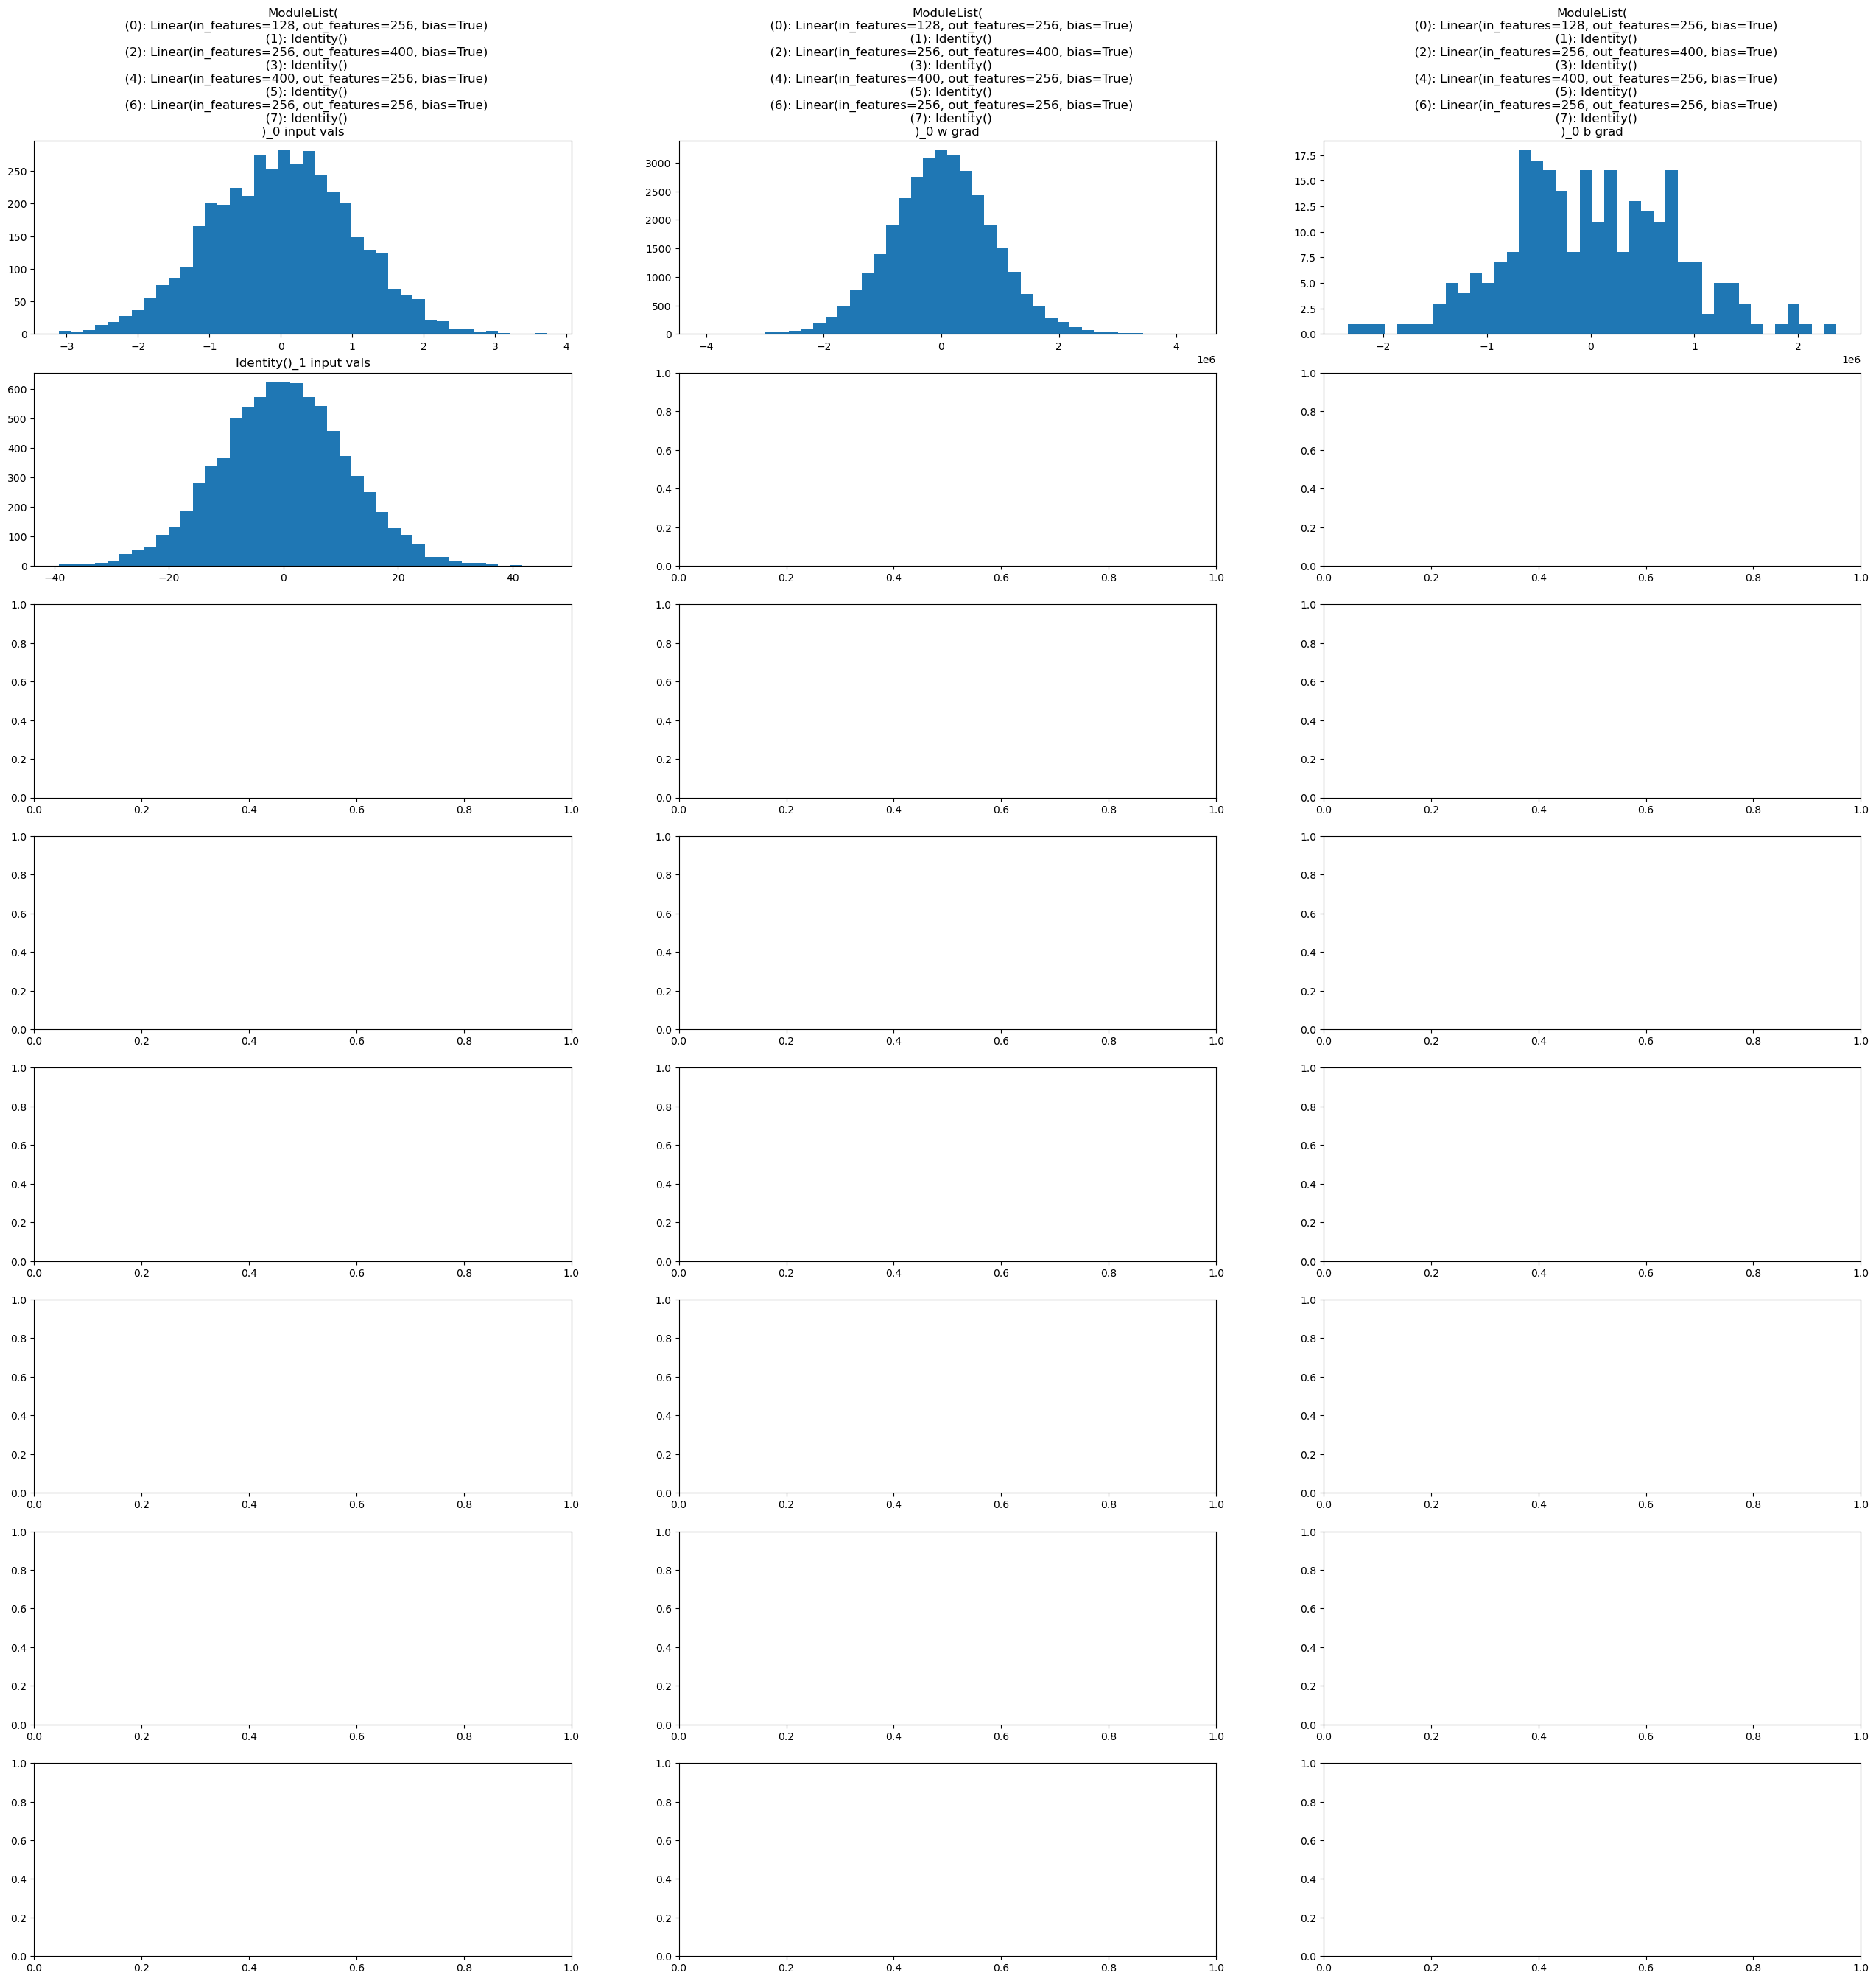

In [ ]:
# first, let's define a multi-layered neural-net with 
# a custom activation
import torch.nn.functional as F
class NeuralNetCust(nn.Module):
    def __init__(self,linear_dims,activation,init=None):
        super().__init__()
        # building all layers
        self.layers = nn.ModuleList()
        self.activations = []
        self.grads = []
        self.init = init
        self.activation_type = activation
        
        for i in range(len(linear_dims)-1):
            self.layers.append(nn.Linear(linear_dims[i],linear_dims[i+1]))
            self.layers.append(activation)
            
        #### Weight Init ####
        # all init common types
        
        # common for relu: sqrt(3/(nin)) * gain
        # for larger variance...
        if init == "kaiming":
            for i in range(len(linear_dims)-1):
                nn.init.kaiming_uniform_(self.layers[i*2].weight)
                nn.init.zeros_(self.layers[i*2].bias)
                
        # uniform: +/- sqrt(2/(n_in+n_out)) * gain
        # accounts for both variances..
        elif init == "xavier":
            for i in range(len(linear_dims)-1):
                nn.init.xavier_uniform_(self.layers[i*2].weight)
                nn.init.zeros_(self.layers[i*2].bias) 
        elif init == "--standard":
            pass
        else:
            for i in range(len(linear_dims)-1):
                nn.init.normal_(self.layers[i*2].weight)
                nn.init.normal_(self.layers[i*2].bias)
            
        
            
    def forward(self,x):
        # storing actications and gradients
        self.activations = []
        for layer in self.layers:
            # adding input
            self.activations.append(x.detach())
            x = layer(x)
            
        return x
    
    def plot_statistics(self):
        '''For each layer will plot:
        1. Gradients of weights (if params)/var.
        2. Inputs/variance.
        '''
        fig,axes = plt.subplots(len(self.layers),3)
        fig.set_size_inches(4*len(self.layers),4*len(self.layers))
        
        for i in range(len(self.layers)):
            # get name of layer
            layer = [name for _,name in self.named_children()]
            current_layer = f"{layer[i]}_{i}"
            
            if isinstance(self.layers[i],nn.Linear):
                # need a way to averag/ look at one-set!
                axes[i][0].hist(self.activations[i].view(-1),bins=40)
                axes[i][0].set_title(f"{current_layer} input vals")
                
                # look over each batch?
                axes[i][1].hist(self.layers[i].weight.grad.view(-1),bins=40)
                axes[i][1].set_title(f"{current_layer} w grad")
                
                axes[i][2].hist(self.layers[i].bias.grad.view(-1),bins=40)
                axes[i][2].set_title(f"{current_layer} b grad")
            else:
                axes[i][0].hist(self.activations[i].view(-1),bins=40)
                axes[i][0].set_title(f"{current_layer} input vals")
               
        fig.suptitle(f"{self.init} init | {self.activation_type} act.",fontsize=20)
        plt.show()
            
    
    


# just plotting for 1 forward and backward pass.
x = torch.randn([32,128])
y = torch.randn([32,256])

neuralnet = NeuralNetCust([128,256,400,256,256],activation=nn.Identity(),init=None)
output = neuralnet(x)
loss = F.mse_loss(output,y)
loss.backward()


# test
for name,layer in neuralnet.named_children():
    print(layer)

# plotting activation statistics
print(neuralnet.layers[0].weight.grad.shape)
neuralnet.plot_statistics()

### This is the same as our last expiriment.
- We used no activation or initialiaztion, and our values exploded.

Now let's try *with* standard (kaiming) intiialization and a ReLU activation, and then a tanh activation:

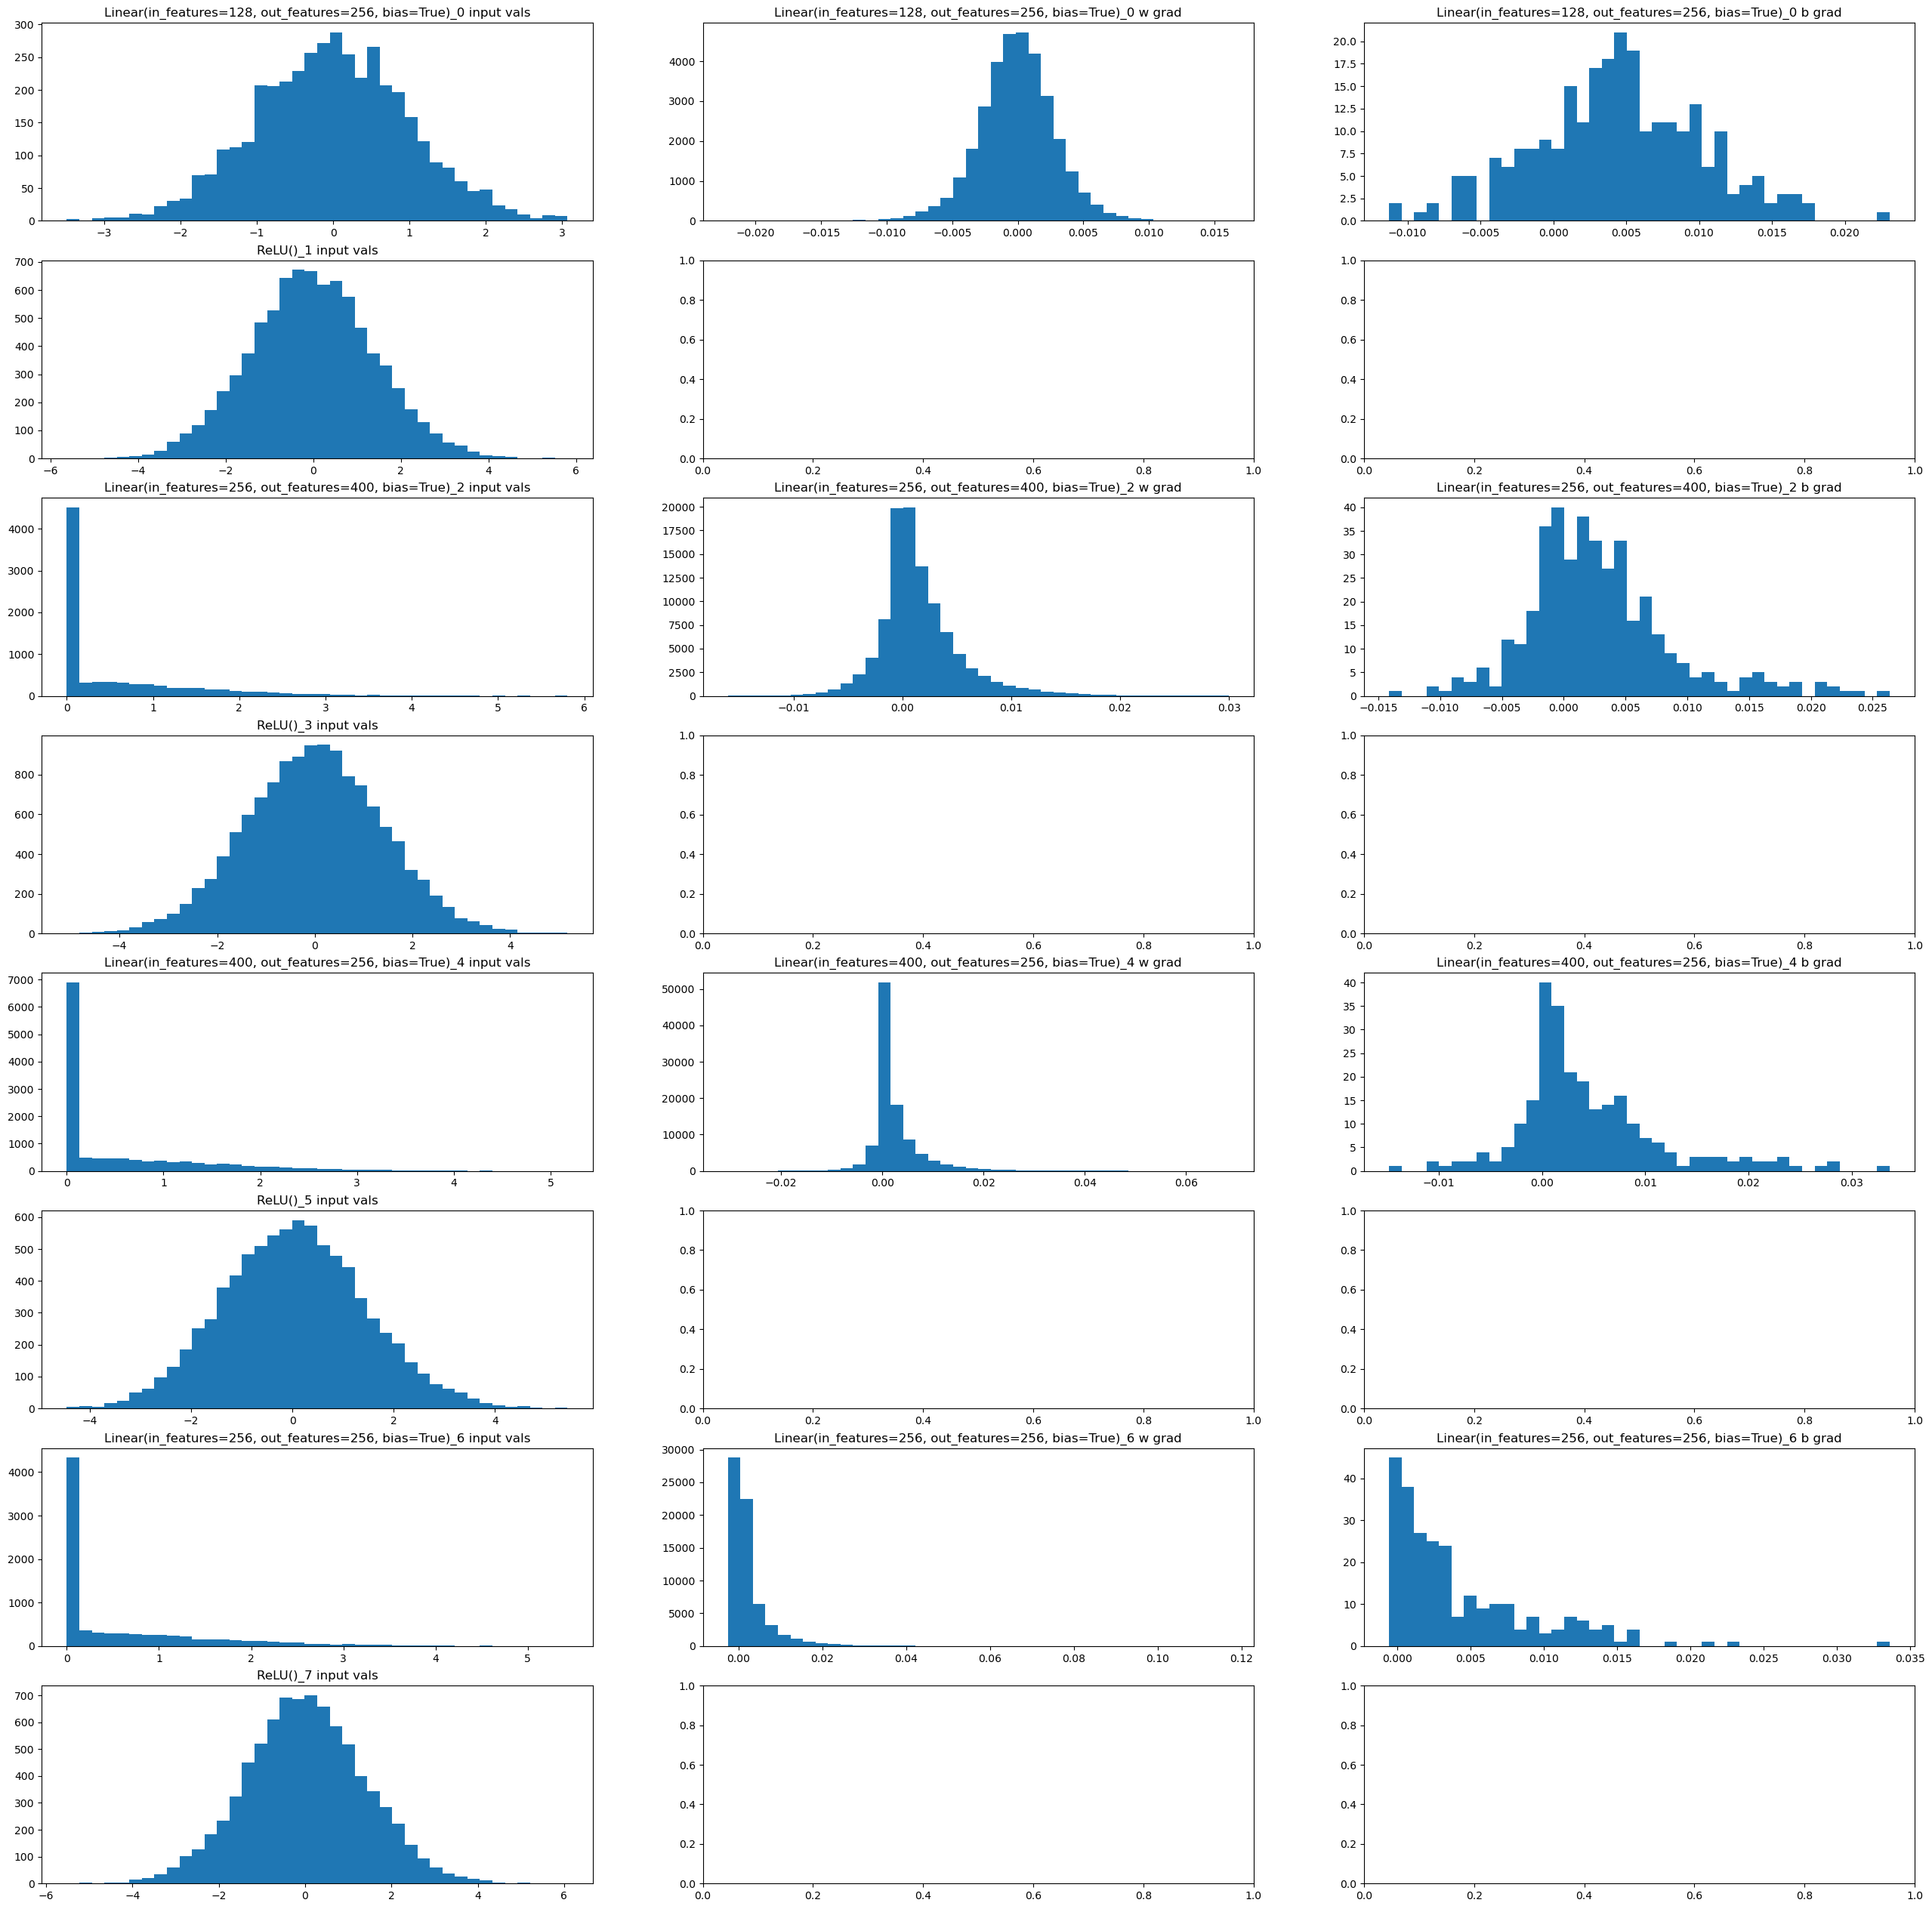

In [ ]:
# RELU and Kaiming he init.
x = torch.randn([32,128])
y = torch.randn([32,256])

neuralnet = NeuralNetCust([128,256,400,256,256],activation=nn.ReLU(),init='kaiming')
output = neuralnet(x)
loss = F.mse_loss(output,y)
loss.backward()


neuralnet.plot_statistics()